In [ ]:
import numpy as np
import pandas as pd, re, requests
from itertools import combinations
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from tqdm.auto import tqdm
import seaborn as sns, matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('diagnoses_icd10.csv')
df.head()

,Unnamed: 0,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,deathtime,icd10_code,icd10_category
0,0,10000032,22595853,1,5723,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,K766,K76
1,1,10000032,22595853,2,78959,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,R188,R18
2,2,10000032,22595853,3,5715,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,K740,K74
3,3,10000032,22595853,4,07070,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,B1920,B19
4,4,10000032,22595853,5,496,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,J449,J44


In [ ]:
# если один и тот же диагноз в одном человеке
df_unique = df[['subject_id', 'icd10_category']].drop_duplicates()

unique_icds = df_unique['icd10_category'].dropna().unique()

cat2idx = {icd: i for i, icd in enumerate(unique_icds)}
idx2cat = {i: icd for icd, i in cat2idx.items()}
n = len(unique_icds)
print(f'unique_cats = {n}')

# сколько пациентов имели одновременно оба кода
co_occurrence = np.zeros((n, n), dtype=int)

for subject_id, group in tqdm(df_unique.groupby('subject_id')):
    cats = group['icd10_category'].unique()
    indices = [cat2idx[cat] for cat in cats if cat in cat2idx]

    for i in indices:
        for j in indices:
            co_occurrence[i, j] += 1

total_patients = df['subject_id'].nunique()
print(f'total_patients = {total_patients}')

# доля пациентов с обоими диагнозами от общего числа пациентов
co_occurrence_fraction = co_occurrence / total_patients

# усл вероятность 
patients_per_code = co_occurrence.diagonal().copy()
patients_per_code[patients_per_code == 0] = 1  # чтобы не делить на 0
conditional_prob = co_occurrence / patients_per_code[:, None]

co_df = pd.DataFrame(co_occurrence, index=unique_icds, columns=unique_icds)
fraction_df = pd.DataFrame(co_occurrence_fraction, index=unique_icds, columns=unique_icds)
cond_df = pd.DataFrame(conditional_prob, index=unique_icds, columns=unique_icds)

unique_cats = 1757


100%|██████████| 223291/223291 [04:27<00:00, 834.27it/s] 


223291=


In [12]:
co_df.to_csv("matrix/cat_co_matrix_counts.csv") # сколько уникальных пациентов имели одновременно диагнозы i и j
fraction_df.to_csv("matrix/cat_co_matrix_fraction.csv") # доля пациентов из всей выборки у которых одновременно были диагнозы i и j
cond_df.to_csv("matrix/cat_co_matrix_conditional_prob.csv") # усл вероятность

In [18]:
cond_df.head()

,K76,R18,K74,B19,J44,F31,F43,Z87,D69,E87,...,V45,V16,W99,P11,B56,W85,P07,A27,Y64,Y21
K76,1.000000,0.224081,0.238723,0.111313,0.135595,0.043288,0.062113,0.416242,0.362768,0.576664,...,0.0,0.0,0.0,0.0,0.000091,0.0,0.0,0.0,0.0,0.0
R18,0.429942,1.000000,0.347583,0.130518,0.128424,0.030187,0.053219,0.414413,0.396091,0.697958,...,0.0,0.0,0.0,0.0,0.000174,0.0,0.0,0.0,0.0,0.0
K74,0.528594,0.401128,1.000000,0.305276,0.172573,0.054571,0.069472,0.453685,0.475232,0.631091,...,0.0,0.0,0.0,0.0,0.000201,0.0,0.0,0.0,0.0,0.0
B19,0.233010,0.142395,0.288597,1.000000,0.155911,0.139349,0.144108,0.364173,0.302113,0.472682,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
J44,0.077499,0.038256,0.044545,0.042570,1.000000,0.051042,0.049275,0.527574,0.165445,0.462966,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


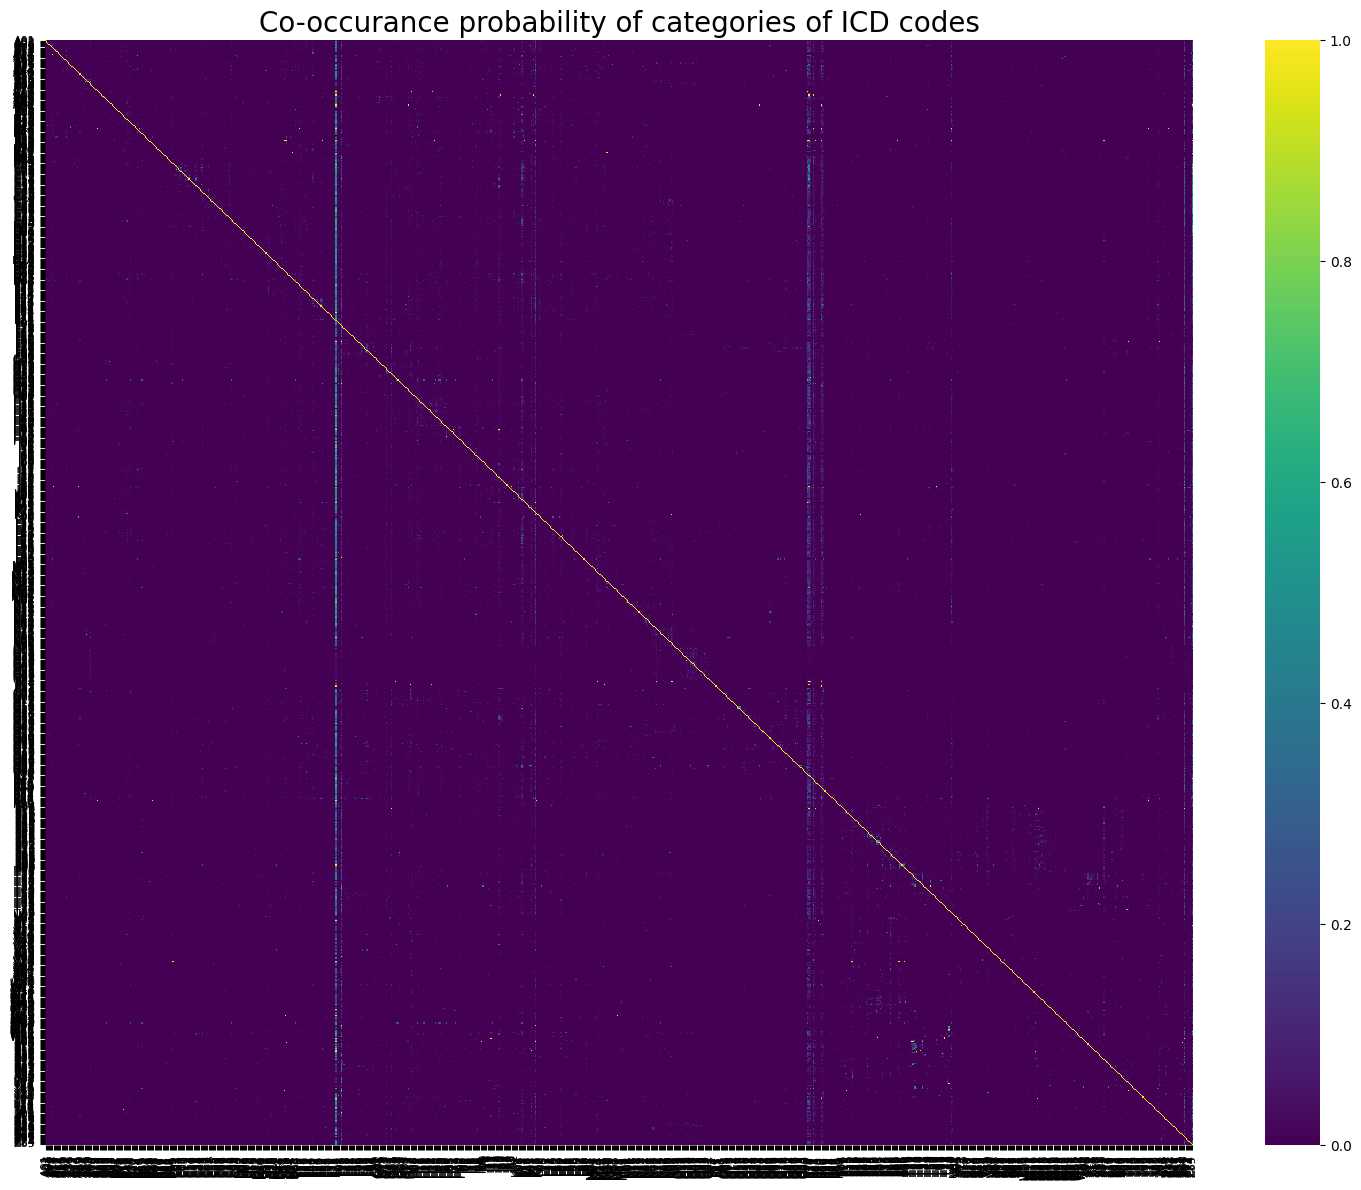

In [42]:
N = 1000
name_1000 = "Co-occurance probability of categories of ICD codes" 
diag_values = np.diag(cond_df)
top_indices = np.argsort(diag_values)[::-1][:N]
top_cats = [idx2cat[i] for i in top_indices]

top_cats_sorted = sorted(top_cats, reverse=False)

top_cond_df = cond_df.loc[top_cats_sorted, top_cats_sorted]
                          
plt.figure(figsize=(15,12))
sns.heatmap(top_cond_df, annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title(name_1000, fontsize=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.savefig(f'pics/{name_1000}.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


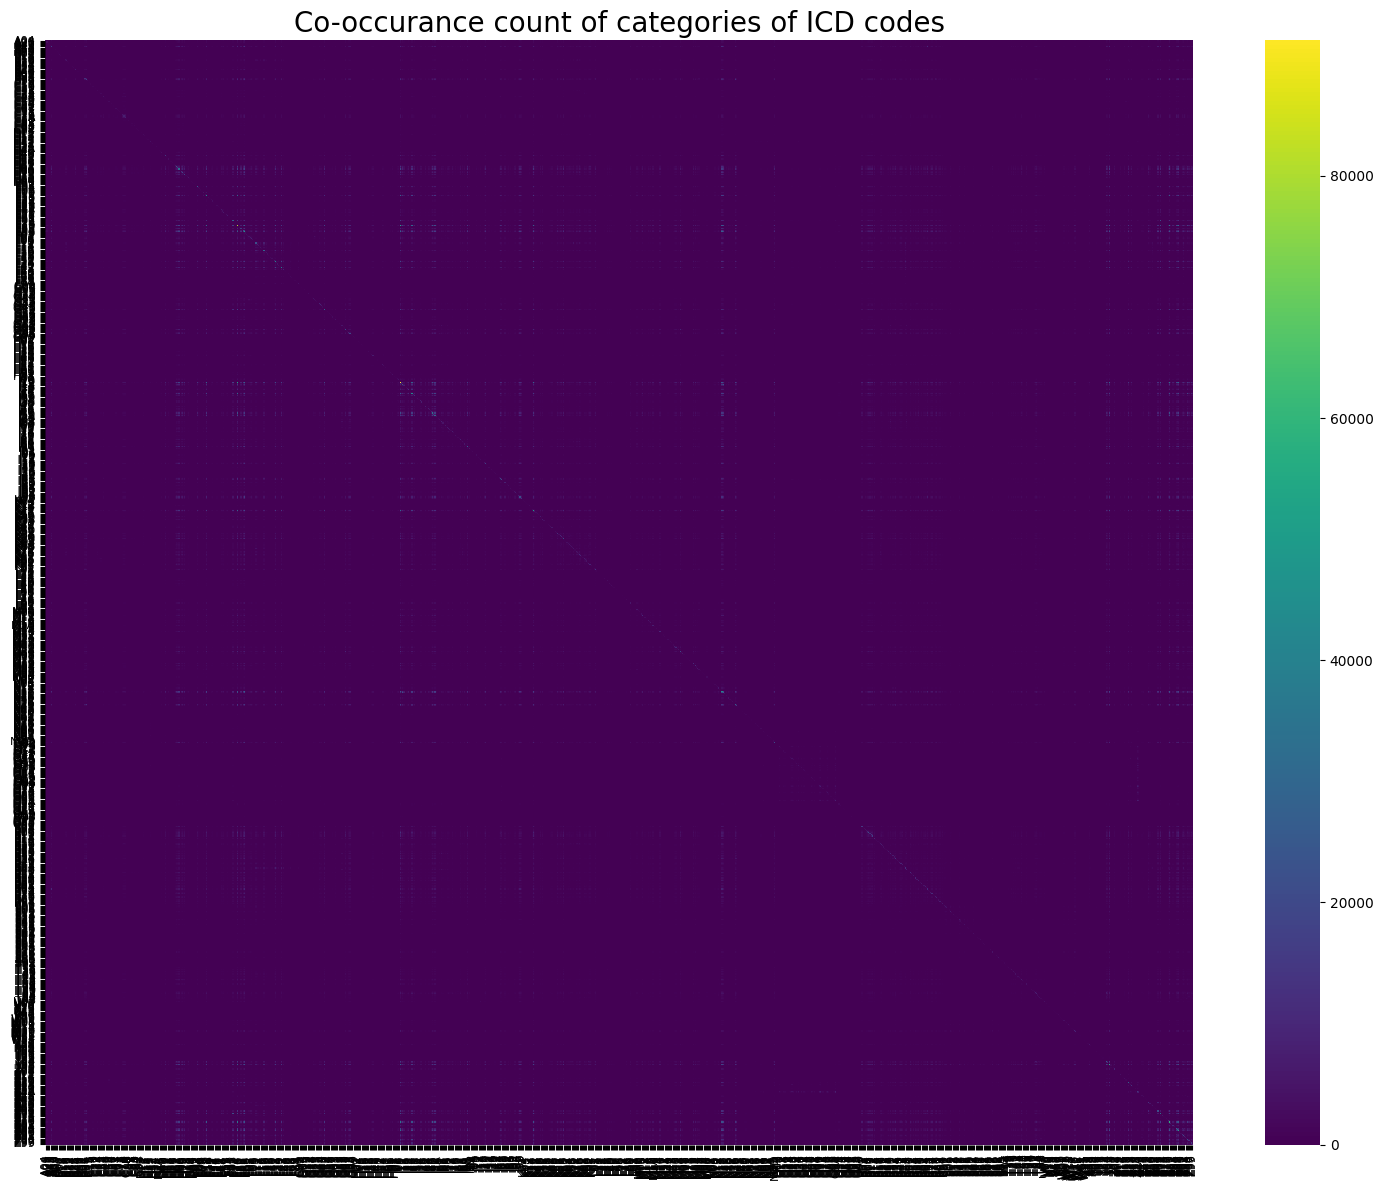

In [43]:
N = 1000
name_1000 = "Co-occurance count of categories of ICD codes"
diag_values = np.diag(co_df)
top_indices = np.argsort(diag_values)[::-1][:N]
top_cats = [idx2cat[i] for i in top_indices]

top_cats_sorted = sorted(top_cats, reverse=False)

top_co_df = co_df.loc[top_cats_sorted, top_cats_sorted]
                          
plt.figure(figsize=(15,12))
sns.heatmap(top_co_df, annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title(name_1000, fontsize=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.savefig(f'pics/{name_1000}.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


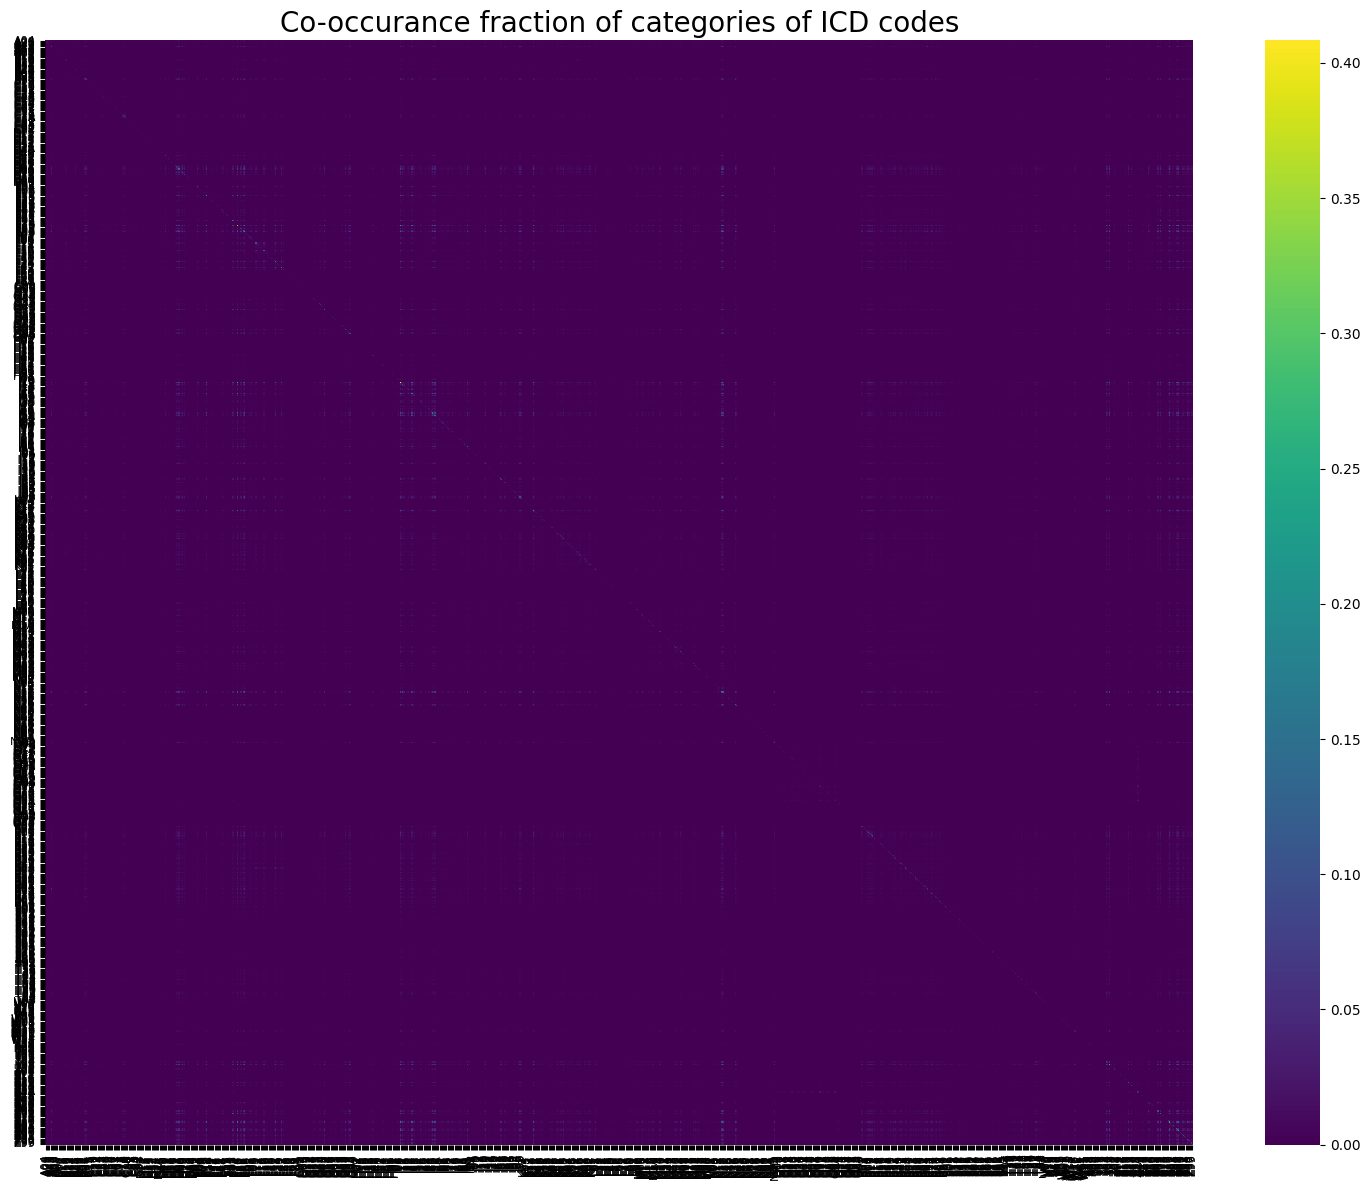

In [44]:
N = 1000
name_1000 = "Co-occurance fraction of categories of ICD codes"
diag_values = np.diag(fraction_df)
top_indices = np.argsort(diag_values)[::-1][:N]
top_cats = [idx2cat[i] for i in top_indices]

top_cats_sorted = sorted(top_cats, reverse=False)

top_fr_df = fraction_df.loc[top_cats_sorted, top_cats_sorted]
                          
plt.figure(figsize=(15,12))
sns.heatmap(top_fr_df, annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title(name_1000, fontsize=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.savefig(f'pics/{name_1000}.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [37]:
# print("top_co_df")
# print(top_co_df)
# print("top_cond_df")
# print(top_cond_df)
# print("top_fr_df")
# print(top_fr_df)

In [ ]:
def top_pairs(mat: np.ndarray, codes: np.ndarray, k: int = 10):
    mat = mat.copy()
    np.fill_diagonal(mat, 0)

    iu = np.triu_indices_from(mat, k=1)
    vals = mat[iu]
    idx_top = np.argpartition(vals, -k)[-k:]
    idx_sorted = idx_top[np.argsort(vals[idx_top])[::-1]]

    pairs = [
        (codes[iu[0][idx]], codes[iu[1][idx]], vals[idx])
        for idx in idx_sorted
    ]
    return pd.DataFrame(pairs, columns=["icd_i", "icd_j", "value"])

codes = np.array(unique_icds)  

top10_count = top_pairs(co_df.to_numpy(), codes, k=10)
top10_fraction = top_pairs(fraction_df.to_numpy(), codes, k=10)
top10_condition = top_pairs(cond_df.to_numpy(), codes, k=10)

print("Top-10 по абсолютному числу пациентов:")
print(top10_count, "\n")

print("Top-10 по доле от всех пациентов:")
print(top10_fraction, "\n")

print("Top-10 по условной вероятности P(j | i):")
print(top10_condition)


TOP-10 по абсолютному числу пациентов:
  icd_i icd_j  value
0   E78   I10  54140
1   E78   Z79  37224
2   Z79   I10  35327
3   E78   I25  31549
4   Z87   E78  31198
5   Z87   I10  30633
6   E78   E11  30435
7   K21   I10  29223
8   Y92   I10  28937
9   E87   I10  28686 

TOP-10 по доле от всех пациентов:
  icd_i icd_j     value
0   E78   I10  0.242464
1   E78   Z79  0.166706
2   Z79   I10  0.158211
3   E78   I25  0.141291
4   Z87   E78  0.139719
5   Z87   I10  0.137189
6   E78   E11  0.136302
7   K21   I10  0.130874
8   Y92   I10  0.129593
9   E87   I10  0.128469 

TOP-10 по условной вероятности P(j | i):
  icd_i icd_j     value
0   O70   Z37  0.998752
1   I13   N18  0.996829
2   O09   Z37  0.963961
3   O25   Z37  0.945420
4   W01   Y92  0.885630
5   Y93   Y92  0.825809
6   C7B   C7A  0.808511
7   T81   Y83  0.802353
8   R64   Z68  0.799929
9   S27   S22  0.784471


In [32]:
# codes_top = pd.unique(
#     top10_condition[['icd_i', 'icd_j']].values.ravel()
# )                       
# codes_top = sorted(codes_top)
# sub = co_df.loc[codes_top, codes_top] 

# plt.figure(figsize=(8,6))
# sns.heatmap(sub, cmap="viridis", annot=True, fmt=".2g",
#             xticklabels=True, yticklabels=True)
# plt.title("Top-pairs – absolute patient counts")
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()


##### Выводы:
Условная вероятность - «Если у пациента обнаружили диагноз i, нужно ли особенно проверять j?» (какова вероятность, что у него также есть j)
Доля от общего числа пациентов - «Сколько людей в популяции имеют обе категории заболевания?»

Описание для overleaf:

\text{Fraction}_{i,j} &= \frac{N_{i,j}}{N_{\text{total}}} \\

\text{Conditional}_{i,j} &= \frac{N_{i,j}}{N_{i}}


N_{i,j} - number of patients with both ICD categories i and j
N_{\text{total}} - total number of patients in the dataset
N_{i} - number of patients with ICD category i


##### Описание для статьи:


Method for Estimating ICD-10 Code Co-Occurrence


To analyze patterns of co-occurring diagnoses among patients, we constructed several co-occurrence matrices based on ICD-10 diagnostic categories. The goal was to quantify how often pairs of diagnostic codes appear together in the medical history of the same patient and to assess the relative strength of these associations.

Preprocess
First, we removed duplicate records of the same diagnosis for a given patient to ensure that each (patient, diagnosis) pair was counted only once. Все коды были приведены к единому виду, число уникальных кодов составило 2908741. Для удобства вычислений было решено использовать категории ICD кодов без учета подкатегорий. Например, код "C50.911" означает «злокачественное новообразование молочной железы, неуточнённый участок правой стороны». Все, что после точки — это подробное описание. Нас же для построения зависимостей между разными виами хаболевания  удовлятворяет просто категория C50 - злокачественное новообразование молочной железы.
После All unique ICD-10 categories were identified and mapped to integer indices for matrix construction. 

For each patient, we recorded all unique категории ICD-10 codes assigned to them, после чего было построено три вида матриц:
1) Co-Occurrence Matrix  
For each patient, we recorded all unique ICD-10 codes assigned to them. We then incremented the co-occurrence matrix for each observed pair of codes. This resulted in a symmetric matrix C, where each entry C  ij represents the number of patients diagnosed with both codes i and j.
2) Fraction Matrix
To obtain a relative frequency measure, the co-occurrence counts were divided by the total number of unique patients:
\text{Fraction}_{i,j} &= \frac{N_{i,j}}{N_{\text{total}}} \\

N_{i,j} - number of patients with both ICD categories i and j
N_{\text{total}} - total number of patients in the dataset

3) Conditional Probability Matrix
We also computed conditional probabilities to reflect how likely code j appears among patients diagnosed with code i. This was calculated by row-normalizing the co-occurrence matrix: where C  ii is the number of patients with code i (on the diagonal). This matrix is asymmetric and captures directional associations between diagnoses.


\text{Conditional}_{i,j} &= \frac{N_{i,j}}{N_{i}}

N_{i,j} - number of patients with both ICD categories i and j
N_{\text{total}} - total number of patients in the dataset
N_{i} - number of patients with ICD category i


These matrices enabled further downstream analysis, such as ranking the most frequently co-occurring diagnosis pairs and visualizing clusters of related conditions using heatmaps.


##### Результаты

<тут будут три хитмапа>

To investigate the structure and interaction of diagnoses, we constructed three pairwise matrices based on ICD-10 3-character categories:
Co-Occurrence Matrix : raw co-occurrence count matrix — how many patients had both diagnoses simultaneously.
Fraction Matrix: normalized co-occurrence matrix — proportion of patients with both diagnoses out of all patients.
Conditional Probability Matrix: proportion of patients with diagnosis j among those who had i.

В результате были выявлены следующие наблюдения:
В первой матрице: codes from the Z-group (Z87) often co-occur with many other codes, reflecting historical or contextual diagnoses. Это логично, так как часто данная категория может сопутствовать разным диагнозам, так как означает "длительное медикаментозноее лечение" и др.



**Можно вставлять что-то типа этого:**

Method for Estimating ICD-10 Code Co-Occurrence
To analyze patterns of co-occurring diagnoses across patients, we constructed several co-occurrence matrices based on 3-character ICD-10 diagnostic categories. The goal was to quantify how frequently diagnostic code pairs appeared together in patient histories and to evaluate the relative strength and directionality of these associations.

1. Preprocessing
To ensure that each diagnosis was counted only once per patient, we removed duplicate (subject ID, ICD code) pairs. All diagnostic codes were standardized to a uniform format. Since our interest lies in capturing general comorbidity patterns rather than detailed subtypes, we aggregated ICD-10 codes to their three-character categories (e.g., C50.911 → C50, denoting “malignant neoplasm of breast”). This reduced noise and improved computational tractability.

We identified all unique ICD-10 categories and mapped them to integer indices to construct matrix representations.

2. Matrix Construction
For each patient, we collected the set of unique ICD-10 categories assigned to them and computed the following matrices:

Co-Occurrence Matrix
For every patient, we considered all pairs of ICD-10 categories present in their records. Each observed pair incremented the corresponding entry in the co-occurrence matrix  C, where:
